### Micrograd

A tutorial by Andrej Karpathy: https://www.youtube.com/watch?v=VMj-3S1tku0&t=938s

<u>Overview</u>: Micrograd is a library built by Karpathy to illustrate backpropagation. It operates only over scalar values, so a neuron is looked at from its individual tiny additions and multiplications. I'm going to follow this tutorial from start to finish in order to gain a better understanding of Autograd and backpropagation.

Karpathy believes that Micrograd is all you need in order to train neural networks. Everything else found in big libraries is just for efficiency purposes. 

In [1]:
from micrograd.engine import Value

In [2]:
# Micrograd contains a "Value" object, which wraps around floats
a = Value(-4.0)
b = Value(2.0)

# A bunch of simple mathematical expressions to highlight Micrograd's functionality 
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()

e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f

In [3]:
# Outcome of forward pass - 24.70
print(f'{g.data:.4f}')

# We can also initialise backpropagation, in this case at the node g. 
g.backward()

# Numerical value of dg/da - 138.83
print(f'{a.grad:.4f}')

# Numerical value of dg/db - 645.58
print(f'{b.grad:.4f}')

24.7041
138.8338
645.5773


#### Backpropagation

Going back through the graph/network and applying the chain rule to evaluate the derivative of the final node, with respect to all the internal nodes (weights) and inputs. This tells us how the nodes/weights and inputs are affecting the final node, i.e. how a and b are affecting g (through the mathematical expression of the neural network).

I.e. above, if we nudge a ever so slightly (making it larger), g will grow by 138.83. Similarly the slope for b will be 645.58. This is how g will respond if a and b are tweaked a tiny amount, in a positive direction.

Neural networks are just mathematical expressions. They take the input data, along with the weights of the network, pass them through some kind of mathematical expression, and the output are your network's predictions or the loss function. 

We're just manipulating scalars here. For actual networks, we would be manipulating n-dimensional tensors - but the math remains the same. Tensors are just arrays of scalars. The operations stay the same; the reason we put them in tensors is that it is computationally more efficient (takes advantage of parrarelisation). 

#### Micrograd from scratch

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# A random function
def f(x):
    return 3*x**2 - 4*x + 5

In [8]:
f(3.0) # prints 20

20.0

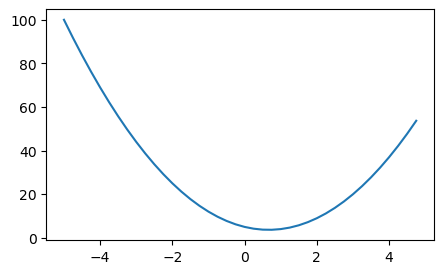

In [14]:
xs = np.arange(-5, 5, 0.25) # an array from -5 to 5 in steps of 0.25
ys = f(xs) # function called on the array

# Plot
plt.figure(figsize=(5, 3))
plt.plot(xs, ys)

#### Understanding the derivative

You are at point x. If you increase it by a tiny value, h - how does the function respond? What is the slope in a small step in a given direction. 

Just looking at the graph above, if we are at x = 3 and add a small number, we expect the function to increase.

In [16]:
# We can try this numerically
h = 0.001
x = 3.0

print("The function's response to adding h: ", f(x + h)) # prints 20.014
print("The slope of the function at x = 3: ", (f(x + h) - f(x)) / h) # 14.00


The function's response to adding h:  20.014003000000002
The slope of the function at x = 3:  14.00300000000243


This slope is just a numerical approximation of the true slope. We have to make h very small in order to converge to the true slope.

It even makes sense if we derive the function ourselves:
3x^2 - 4x + 5 --> 6x - 4. At x = 3, dy/dx = 14. 

In [18]:
# At some point, this derivative is 0

h = 0.00001
x = 2/3
print((f(x + h) - f(x)) / h)

# And looking at the graph, the function likely indeed bottoms out at y = 3 and x = 2/3. 

3.0000002482211127e-05


In [19]:
# A slightly more complex example
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
d # 4.0

4.0

What is the derivative of d with respects to a, b, and c? What does this tell us?

In [20]:
h = 0.0001

# inputs - the points where we evaluate d with respect to a,b,c
a = 2.0
b = -3.0
c = 10.0

# With respect to a
d1 = a*b + c
a += h
d2 = a*b + c
print("d1: ", d1) # 4.0
print("d2: ", d2) # 3.99

# d2 - d1 is how much the function increases. This is then normalised by h to get the slope
print("Slope: ", (d2 - d1) / h) # -3.0



d1:  4.0
d2:  3.999699999999999
Slope:  -3.000000000010772


Why does it decrease? A is slightly more positive. Since a is multiplied with a negative number, we actually get more of a negative number. So the slope decreases.

Numerically makes sense: d = a*b + c --> dd/da = b = -3.0.

We can also calculate the slope of d with respect to a and c, but will skip the details. dd/db = a = 2.0. dd/dc = 1.

#### Value

Neural networks are massive expressions. We need data structures that contain these data structures. This is what the Value object will do.

We need to keep pointers about what values produce what other values. 
- This is where the _children argument comes in. 
- _op is added to keep track of the operation between the children nodes that result in the Value object.
- grad maintains the gradient with respect to whatever node we're on. 0 means no effect (since this is not changing the loss function). At initialisation we assume that the weights do not impact the output. 

In [4]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # In a set for efficiency (?)
        self._op = _op
        self.label = label

    # This is in order to return a nice string rather than the location of object in memory
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # In order to add 2 Value objects together
    def __add__(self, other): 
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad 
        out._backward = _backward

        return out
    
    # In order to multiply 2 Value objects together
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = other.grad * out.grad
            other.grad = self.grad * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward

        return out

In [16]:
# Operations in action
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label='d' 
d # worked well 

f = Value(-2.0, label='f')
L = d * f; L.label='L' # output of graph
L

Value(data=-8.0)

In [43]:
# We get the children nodes, a*b and c. 
print(d._prev)

{Value(data=-6.0), Value(data=10.0)}


In [49]:
# Returns '+', so we know that d was produced through an addition of the two children Values
print(d._op)

+


#### Visualisations

Visualise the expression graphs.

In [36]:
from graphviz import Digraph 

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        # for any value in the graph, create a rectangular 'record' node for it
        dot.node(name=uid, label='{%s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of an operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [17]:
# Add gradients calculated below
L.grad = 1.0
d.grad = -2.0 
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = -3.0 * -2.0
b.grad = 2.0 * -2.0

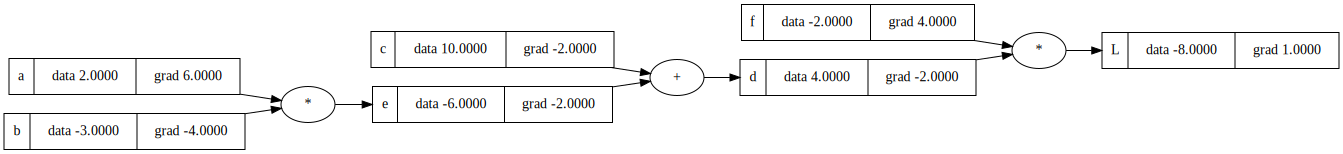

In [8]:
draw_dot(L)

In the function below, playing around with different gradients and manipulations to see how it affects the network. By adding h to each of the variables in the second part below, we can then calculate the gradient of L with respect to those terms.

1. We start with L - the output. What is the derivative of L with respect to L? In other words, if I change L by a tiny amount h, how much does L change? Obviously it is proportional, so the derivative is 1. 
2. Next is d - what is dL/dd? If you know calculus: L is d * f, so dL/dd is just f. Analytically, this is the same as: 
* (f(x+h) - f(x)) / h --> ((d + h) * f - (d * f)) / h --> (df + hf - df) / h --> hf / h --> h.  
3. Likewise, the gradient of L with respect to f is just d, since L = d * f.
4. Next, we want dL/dc. We know how d impacts L, and we know how c impacts d, so we should be able to put that info together. d = c + e, therefore, dd/dc = 1, following same explanation as above. This is the local derivative (in that it is local to d, c, and but is not what we want - we want the global derivative of L with respect to c). We find out dL/dc at this point using the chain rule (shown below). So - we multiply dL/dd by dd/dc to get dL/dc. -2.0 * 1.0 = -2.0.
5. By symmetry, dd/de will also be 1 and dL/de = -2.0 * 1.0 = -2.0. So basically what a '+' node does is route the gradients - their local derivative is always 1.0. So, the previous derivative gets passed to the nodes being summed.
6. Next we want dL/da. Since e = a*b, using the chain rule, we know that dL/da = dL/de * de/da. de/da = b = -3.0. Therefore, dL/da = -2.0 * -3.0 = 6.0
7. And dL/db = dL/de * de/db. de/db = a = 2.0. dL/db = -2.0 * 2.0 = -4.0.


<b><u>And that is pretty much backpropagation.</u></b> We always know the derivative L with respect to whatever nodes & operations that produced L. We just recursively multiply local derivatives, i.e. recursively apply the chain rule - back through the computational graph.

<u>The chain rule</u>: If a variable z depends on the variable y, which itself depends on the variable x, then z depends on x as well, via the intermediate variable y. The chain rule is then expressed as:
- dz/dx = dz/dy * dy/dx

<u>Intuitive explanation</u>: z = car, y = bicycle, x = man. If a car travels 2x as fast as a bicycle, and the bicycle is 4x as fast as a walking man, then the car travels 2 * 4 = 8 times as fast as the man. The rate of change of relative positions of the car and the bicycle is dz/dy = 2 and dy/dx = 4. So, the rate of change of the relative positions of the car and the walking man is 2 * 4 = 8. 

In [22]:
def lol():
    """ Inline gradient check """

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d' 
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label='d' 
    #d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data 

    print((L2 - L1) / h)

lol()

6.000000000021544


#### Preview of a single optimisation step

We will nudge our inputs to make L go up. If we want to do this, we need to go in the direction of the gradient.

In [18]:
# Increase a by a small amount. 0.01 is the step size.
a.data += 0.01 * a.grad

# We do it for all the other leaf nodes as well, i.e. those we have control over
# The others are created by operations between those leaf nodes
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# And we re-run the forward pass
e = a * b
d = e + c
L = d * f

# Since we're nudging L in a positive direction, we expect it to be "less negative"
# And indeed, from -8 --> -7.29
print(L.data)

-7.286496


#### Backpropagation example with a neuron

A neuron takes in (multiple) inputs * weights + bias. This bias is the innate "trigger happiness" of the neuron and is regardless of the input. All this is then passed through an activation function, which is essentially a squashing function. E.g. a sigmoid function squeezes the inputs to be between 0 and 1. A tanh function squeezes the inputs to be between -1 and 1. 

We have to manually implement our own tanh function because tanh is a hyperbolic function. We have only operations for additions and multiplications; you can't make a tanh function out of these only. You also need exponentation. We've added this to the Value class. We could also have created a 'exp' method and used this; this would be the most atomic piece. But the most important thing is just to calculate the local derivative of a node, for that we don't need the most atomic pieces and we can create a tanh method to do this directly. As long as we know it's derivative, then we will be able to backpropagate through it.

In [25]:
# Example neuron

# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights = "synaptic strength" of each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b') # a strange number in order to facilitate understanding of backprop step

# Inputs get multiplied by weights
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

n = x1w1x2w2 + b; n.label='n'

# Activation function
o = n.tanh()

#### Backprop notes

1. The gradient of o with respect to itself is just 1.0
2. To find do/dn, we need to know the derivative of tanh, which is 1 - tanh(x)^2 --> 1 - tanh(n)^2 --> 1 - o^2. 
* Conveniently, o^2 is 0.5, so do/dn = 1.0 - 0.5 = 0.5.
3. Next, we have a + node, which means the gradient will flow through to x1w1x2w2 and b, = 0.5.
4. Same for x1w1 and x2w2.
5. For x1, the gradient will be w1.data * x1w1.grad = -3.0 * 0.5.
6. For w1, the gradient will be x1.data * x1w1.grad = 2.0 * 0.5. 
7. Same for x2 and w2. x2 is 0, so gradient of w2 will be 0. This means that if I change w2, the output doesn't change at all. There is no gradient here. 

In [32]:
# Backprop step to fill in the gradients
# The gradient of o with respect to all the nodes (but the weights specifically, since this is what is changed in optimisation)
o.grad = 1.0
n.grad = 0.5
b.grad = 0.
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = -1.5
w1.grad = 1.0
x2.grad = 0.5
w2.grad = 0

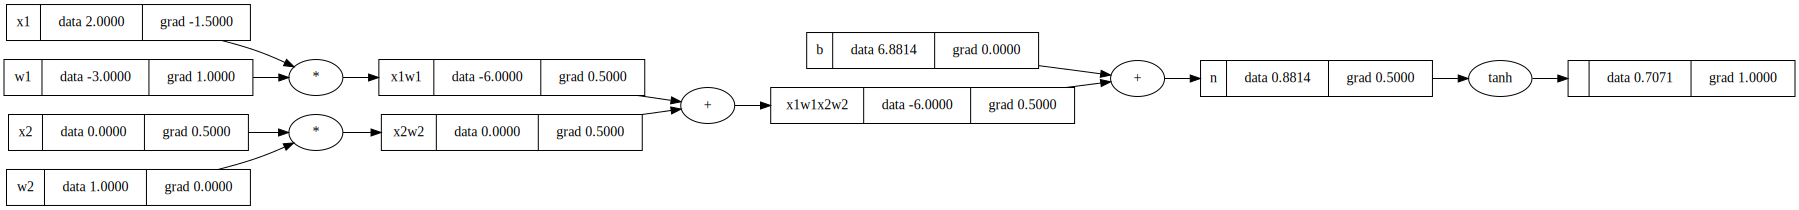

In [33]:
# Can see the tanh function has been added between n and o, squeezing n slightly.
# Can try higher values of b to see this in action. 
draw_dot(o)

#### Autograd

We obviously don't want to calculate the gradients manually, so we codify this operation in the Value class. We added a _backward that is an empty function to the class above - so be default it does nothing. For example, it would not calculate the gradient of a leaf node.

In [18]:
# Example neuron
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights = "synaptic strength" of each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b') # a strange number in order to facilitate understanding of backprop step

# Inputs get multiplied by weights
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

n = x1w1x2w2 + b; n.label='n'

# Activation function
o = n.tanh(); o.label='o'

In [7]:
# In the _backward() method, there is a * out.grad, which is initialised to 0.0
# So, as a base case, we need to manually initialise o.grad to 1.0.
# Then we will be able to call backward() on the other nodes.
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

# All the others are leaf nodes and don't require it?
# Karpathy's tutorial has them updating.

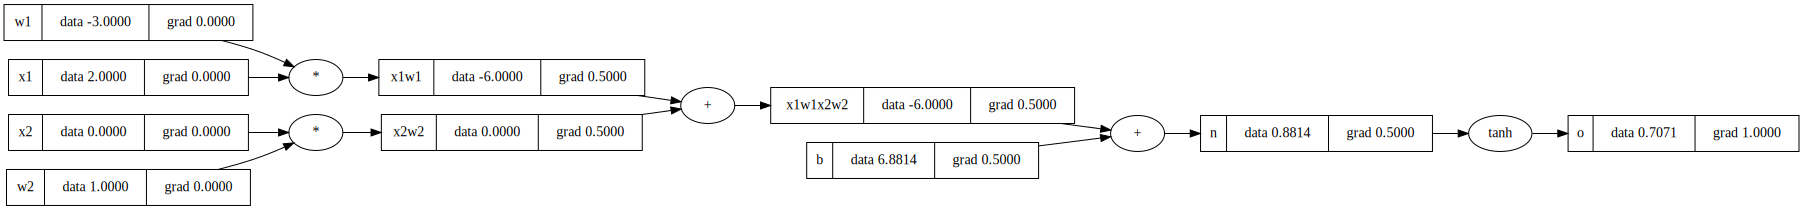

In [8]:
draw_dot(o)

For clarity will post the class again below. We will modify it so that we don't have to manually call backward() every time. 

We have to do a forward pass and then we want to automatically go backward through the expression. In order to do that, we need to have the order of operations correct, i.e. if d is made of b and c, we need to calculate the gradient of d first before b and c (in the backpropagation order). This ordering can be achieved using topological sort. The topological sort orders the graph so that all the edges only go from left to right. DAG. 

In [14]:
# Build a topological graph - starting from w1 and x1. 
# It starts at o, adds all the children, and then adds itself. 
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [15]:
# We need it to go in reversed order
for node in reversed(topo):
    node._backward()

In [27]:
# Edit the class so that we have a proper backward method

class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # In a set for efficiency (?)
        self._op = _op
        self.label = label

    # This is in order to return a nice string rather than the location of object in memory
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # In order to add 2 Value objects together
    def __add__(self, other): 
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
        out._backward = _backward

        return out
    
    # In order to multiply 2 Value objects together
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.grad * out.grad
            other.grad += self.grad * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

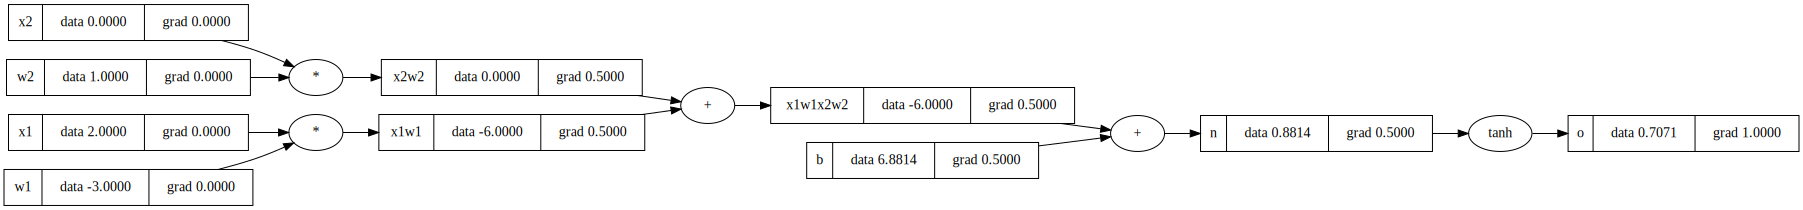

In [19]:
# Gradients added in one step - except for inputs and weights?
o.backward()
draw_dot(o)

#### Fixing a bug

A bug arises in specific conditions. The plot below is incorrect. The forward pass works - b = a + a. But the gradient db/da is not 1, it would be 2 (1 + 1). 

What's happening is in the _backward method, self.grad in this case is set to 1.0, as is other.grad. Because we're doing a + a, self and other are actually the exact same object. We are overriding the gradient - setting it to 1, and then again to 1. This is why it stays at 1. So if we use a variable more than once, we have a problem during the backward pass. 

The solution is that we have to add the gradients, not set them. So we change self.grad to += other.grad * out.grad (and the same for other.grad).

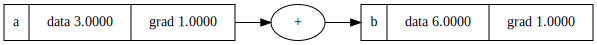

In [26]:
# Incorrect
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

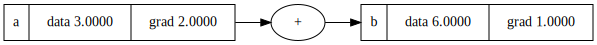

In [24]:
# Correct
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

#### Breaking up a tanh

We could have broken up the tanh into its components rather than than implementing a tanh method. We will do that now in order to practice.

So below:
* Modified addition and multiplication methods so that ordering of values passed doesn't matter
* Exponentiation method implemented
* Division method implemented - but a more powerful method of division. a / b is equivalent to a * (1 / b) and a * b^-1. So Karpathy prefers to implement a method for a^k. This needs to be differentiable. As a special case, k = -1 will be division. This implementation is more general than just a simple division.
* __pow__ method. The power rule says that the local derivative of ax^n is n * ax^n-1. We then multiply by out.grad to apply the chain rule.

In [39]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children) # In a set for efficiency (?)
        self._op = _op
        self.label = label

    # This is in order to return a nice string rather than the location of object in memory
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # In order to add 2 Value objects together
    def __add__(self, other): 
        other = other if isinstance(other, Value) else Value(other) # allows addition with non-Value objects
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
        out._backward = _backward

        return out
    
    # In order to multiply 2 Value objects together
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # allows multiplication with non-Value objects
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.grad * out.grad
            other.grad += self.grad * out.grad
        out._backward = _backward

        return out
    
    # Raise to a power
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers"
        out = Value(np.power(self.data, other), (self, ), f'^{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    # other * self
    def __rmul__(self, other):
        return self * other
    
    # Division
    def __truediv__(self, other):
        return self * other**-1
    
    # Negation
    def __neg__(self):
        return self * -1

    # Subtraction (addition by a negation)
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(np.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        self._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [34]:
# Now can operate with non-Value objects
print(Value(2.0) + 1)
print(Value(2.0 * 2))
print(4 * Value(6.0))

a = Value(2.0)
print(a.exp())

b = Value(4.0)
print(a / b)

print(a - b)

Value(data=3.0)
Value(data=4.0)
Value(data=24.0)
Value(data=7.38905609893065)
Value(data=0.5)
Value(data=-2.0)


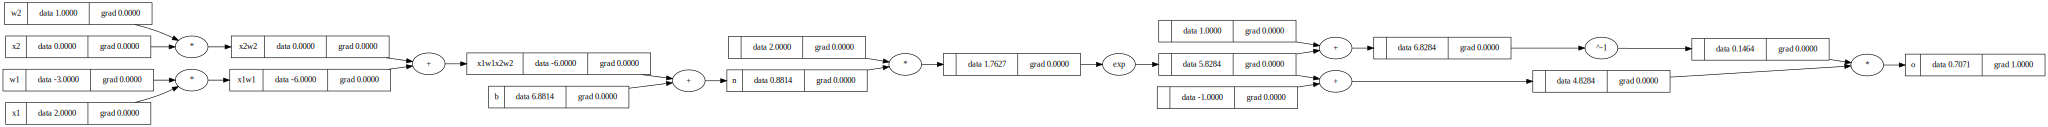

In [41]:
# Will change the network above to use exp instead of tanh. For illustrative purposes
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights = "synaptic strength" of each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b') # a strange number in order to facilitate understanding of backprop step

# Inputs get multiplied by weights
x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'

n = x1w1x2w2 + b; n.label='n'

# Tanh but using base exponent version instead
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label='o'

o.backward()
draw_dot(o)

In [ ]:
## Gradients not working generally above, but especially for leaf nodes. Karpathy's do. 
## Forward pass is correct anyway.

You can use tanh or the atomic elements of exp, addition, subtraction. It doesn't matter so long as you're able to do a forward pass and a backward pass. So as long as you can:
* Perform the necessary operations between weights & inputs + children nodes (additions, multiplications, etc.)
* Calculate the local gradient (the derivative of a node with respect to its children (or is it parent?) node)
* Chain the gradient (calculate the derivative with respect to the loss function??)

Then, you can create a neural network.

#### Pytorch implementation

Micrograd is a scalar-value engine. In Pytorch, everything is based around tensors (n-dimensional arrays of scalars).
* Casted to be double as python uses double floating point numbers (float64), but Pytorch uses float32 unless casted.
* Because they are leaf nodes, by default Pytorch assumes that they do not require gradients - for efficiency reasons. In this case, you have to explicitly tell it you do want the gradients. 
* data.item() strips the numerical value from the tensor object. 


In [2]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o)
print(o.data.item())
o.backward()

print('----------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w2', w1.grad.item())

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
0.7071066904050358
----------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w2 1.0000002567688737
